# 3D circle estimation from its 2D projection

This notebook implements the algorithm described in Chen et al. 2004, which finds the 3D circle from its 2D projection, i.e., an ellipse.

> [Qian Chen, Haiyuan Wu, and Toshikazu Wada, "Camera Calibration with Two Arbitrary Coplanar Circles," ECCV 2004.](https://link.springer.com/chapter/10.1007/978-3-540-24672-5_41)



- Input
  - $K$: Intrinsic parameter of the camera
  - Position, size, and orientation of the ellipse
    - Use `cv2.fitEllipse()`.
    - The ellipse should be described in the lens-undistorted image coordinate.  That is, undistort the image before finding the ellipse.
  - (Optional) Radius of the circle
- Output
  - Two possible solutions of the 3D circle (center and normal)


## Input

This cell prepares a toy example data.

3D Circle:
  o: [[-12.39677931  -5.34037455  13.10287522]]
  n: [[ 0.10605468 -0.17865989 -0.97817843]]
  r: 1
2D Ellipse (by cv2.fitEllipse()):
  cx, cy: (35.91388702392578, 118.00288391113281)
  h, w: (41.3243522644043, 51.050025939941406)
  deg: 77.92831420898438


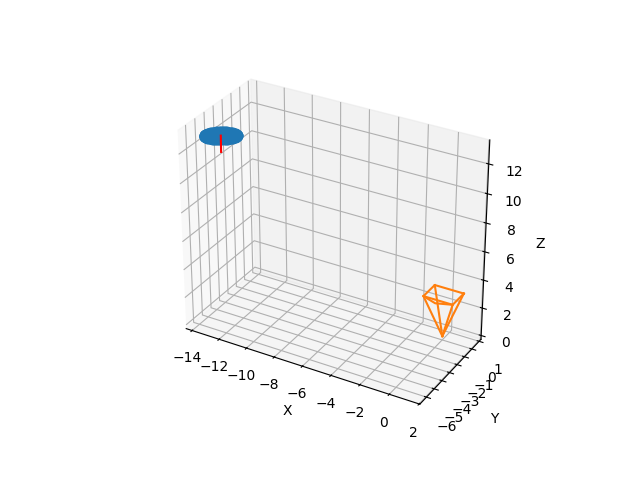

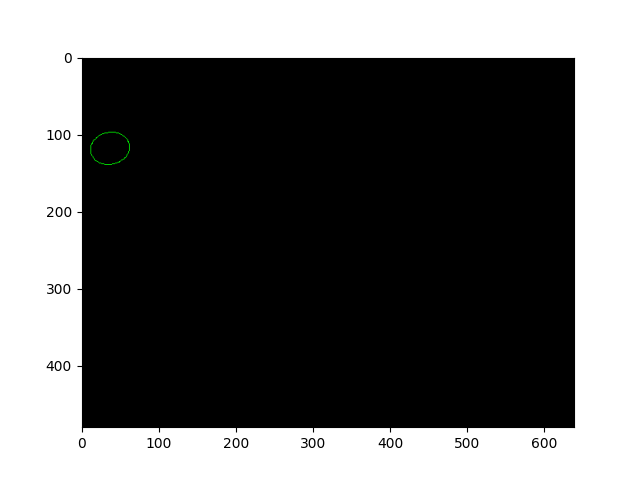

In [1]:
%matplotlib widget
import sys, os
import cv2
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pycalib

# Camera intrinsics
WIDTH = 640
HEIGHT = 480
FL_gt = 300
K_gt = np.array([[FL_gt, 0, WIDTH/2], [0, FL_gt, HEIGHT/2], [0, 0, 1]]).astype(np.float64)  # VGA camera
R_gt = np.eye(3)
t_gt = np.zeros((3, 1))

# 3D circle
C_r = 1
C_o = np.random.normal(size=3) * 5
C_o[2] = np.abs(C_o[2]) + 10 # Z > 0
C_n = np.random.normal(size=3)
C_n[2] = - np.abs(C_n[2]) # Z < 0 (facing to the camera)
C_n /= np.linalg.norm(C_n)

# 3D points on the 3D circle
## two vectors perpendicular to the normal vector
v1 = np.array([C_n[1], -C_n[0], 0])
v1 /= np.linalg.norm(v1)
v2 = np.cross(C_n, v1)
v2 /= np.linalg.norm(v2)
## 3D points on the circle
N = 100
t = np.linspace(0, 2*np.pi, N)
v1 = v1.reshape(3, 1)
v2 = v2.reshape(3, 1)
C_n = C_n.reshape(3, 1)
C_o = C_o.reshape(3, 1)
P = C_o + C_r * (v1 * np.cos(t) + v2 * np.sin(t))
P = P.T
print(f'3D Circle:\n  o: {C_o.T}\n  n: {C_n.T}\n  r: {C_r}')

# Project 3D points to 2D
p_gt = cv2.projectPoints(P.T, cv2.Rodrigues(R_gt)[0], t_gt, K_gt, None)[0].squeeze()
ellipse_gt = cv2.fitEllipse(p_gt.reshape((N, 1, 2)).astype(np.float32))
print(f'2D Ellipse (by cv2.fitEllipse()):\n  cx, cy: {ellipse_gt[0]}\n  h, w: {ellipse_gt[1]}\n  deg: {ellipse_gt[2]}')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(P[:,0], P[:,1], P[:,2], 'o-')
ax.plot([C_o[0], C_o[0] + C_n[0]], [C_o[1], C_o[1] + C_n[1]], [C_o[2], C_o[2] + C_n[2]], 'r-')
pycalib.plotCamera(ax, R_gt.T, -R_gt.T@t_gt, scale=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
plt.show()


img = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
cv2.ellipse(img, ellipse_gt, (0, 255, 0), 1)
plt.figure()
plt.imshow(img)
plt.show()


## High-level API

This cell finds two possible solutions from the result of `cv2.fitEllipse()`.

- Both solutions reproduce the same 2D ellipse.
- The normal vectors are oriented towards the camera (i.e., the Z value is negative).


2D Ellipse Center: 35.9, 118.0
Projection of 3D Circle Center: 37.6, 118.7
Projection of 3D Circle Center: 36.2, 117.7


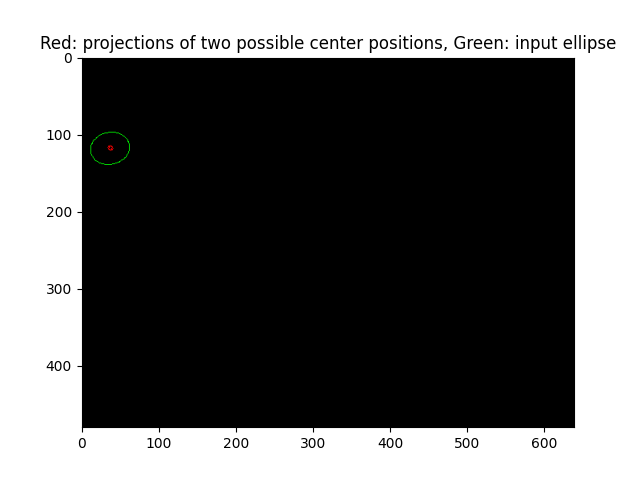

In [2]:
# find the 3D circle from the ellipse
c_candidates, n_candidates = pycalib.circle.solve_circle_3d(K_gt, ellipse_gt, radius=C_r)


# check if either of the solutions is correct
for c, n in zip(c_candidates, n_candidates):
    if np.allclose(c, C_o, atol=1e-4) and np.allclose(n, C_n, atol=1e-4):
        break
else:
    assert False


# debug
img = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
cv2.ellipse(img, ellipse_gt, (0, 255, 0), 1)

# project two circle centers to 2D
print(f'2D Ellipse Center: {ellipse_gt[0][0]:.1f}, {ellipse_gt[0][1]:.1f}')
p = cv2.projectPoints(np.array(c_candidates), cv2.Rodrigues(R_gt)[0], t_gt, K_gt, None)[0].squeeze()
for pi in p:
    print(f'Projection of 3D Circle Center: {pi[0]:.1f}, {pi[1]:.1f}')
    cv2.circle(img, tuple(pi.astype(int)), 3, (0, 0, 255), 1)

plt.figure()
plt.imshow(img[:,:,::-1])
plt.title(r'Red: projections of two possible center positions, Green: input ellipse')
plt.show()

## Low-level API

### `ellipse_to_quadric()`

`cv2.fitEllipse()` returns the ellipse as a rotated rectangle parameterized by

- center $u, v$,
- width, height $a, b$, and
- angle $\phi$.

These parameters satisfy the quadric equation of the form
\begin{equation}
\begin{split}
& \left(\frac{\cos^2\theta}{a^2} + \frac{\sin^2\theta}{b^2}\right) (x-u)^2 +
2 \cos\theta \sin\theta \left(\frac{1}{a^2}-\frac{1}{b^2}\right) (x-u) (y-v) +
\left(\frac{\sin^2\theta}{a^2} + \frac{\cos^2\theta}{b^2}\right) (y-v)^2
= 1 \,, \\
& A (x-u)^2 + 2B (x-u)(y-v) + C (y-v)^2 = 1 \,, \\
& Ax^2 + 2Bxy + Cy^2 - (2Au + 2Bv)x - (2Cv + 2Bu)y + Au^2 + 2Buv + Cv^2 - 1 = 0 \,, \\
& Ax^2 + 2Bxy +Cy^2 + 2Dx + 2Ey + F = 0 \,,
\end{split}
\end{equation}
where
- $A = \frac{\cos^2\theta}{a^2} + \frac{\sin^2\theta}{b^2}$,
- $B = \cos\theta \sin\theta \left(\frac{1}{a^2}-\frac{1}{b^2}\right)$,
- $C = \frac{\sin^2\theta}{a^2} + \frac{\cos^2\theta}{b^2}$,
- $D = - Au - Bv$,
- $E = - Bu - Cv$,
- $F = Au^2 + 2Buv + Cv^2 - 1$, and
- $\theta = \phi + \pi/2$

`ellipse_to_quadric()` returns the parameters $A, \dots, F$ from an ellipse given as a rotated rectangle.

- The parameters `u0` and `v0` are used to normalize the ellipse position.  This is an important step for estimating the 3D circle parameters from the returned $A, \dots, F$.
  - This means that $A, \dots, F$ are not *valid* in the original image coordinate system.
  - If you want to use $A, \dots, F$ as is, e.g., to draw the ellipse in the image, set `u0` and `v0` be zeros.


## `solve_circle_from_quadric()`

`solve_circle_from_quadric()` calculates the two possible solutions of the 3D circle center and the normal from the 2D ellipse described by $A, \dots, F$.

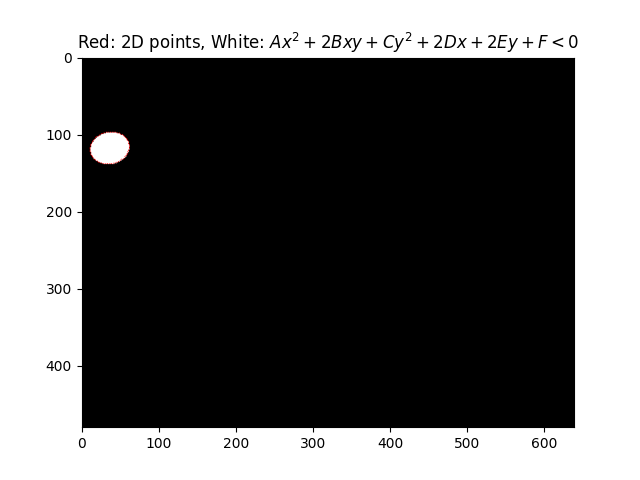

In [3]:
# convert ellipse (cx, cy, h, w, deg) to conic (A, B, C, D, E, F)
A, B, C, D, E, F = pycalib.circle.ellipse_to_quadric(ellipse_gt, K_gt[0, 2], K_gt[1, 2])

# [DEBUG] fill ellipse in white using the estimated A, B, C, D, E, F
img = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
pycalib.circle.draw_ellipse_quadric(img, K_gt[0,2], K_gt[1,2], A, B, C, D, E, F, color=(255, 255, 255), thickness=-1)
# draw 2D points by red used for fitting
img[p_gt[:,1].astype(int), p_gt[:,0].astype(int)] = (0, 0, 255)
plt.figure()
plt.imshow(img[:,:,::-1])
plt.title(r'Red: 2D points, White: $Ax^2 + 2Bxy + Cy^2 + 2Dx + 2Ey + F < 0$')
plt.show()

# solve the circle from the quadric
c_candidates, n_candidates = pycalib.circle.solve_circle_from_quadric(A, B, C, D, E, F, K_gt[0,0], radius=C_r)
#print(f'Center Candidates: {c_candidates}')
#print(f'Normal Candidates: {n_candidates}')
#print(f'Ground Truth: {C_o.T}, {C_n.T}')

# check if either of the solutions is correct
for c, n in zip(c_candidates, n_candidates):
    if np.allclose(c, C_o, atol=1e-4) and np.allclose(n, C_n, atol=1e-4):
        break
else:
    assert False

